<img src="/EMT_Ph1_SSN_DufourRLC_images/temp.png" width="500" align="left">

In [68]:
import villas.dataprocessing.readtools as rt
import matplotlib.pyplot as plt
import dpsimpy

model_name = "EMT_Ph1_DufourRLC";

#Simulation parameters
time_step = 0.0001;
final_time = 0.1;
switch_close_time = 0.05

# Nodes
gnd = dpsimpy.emt.SimNode.gnd
n1 = dpsimpy.emt.SimNode('n1', dpsimpy.PhaseType.Single)
n2 = dpsimpy.emt.SimNode('n2', dpsimpy.PhaseType.Single)
n3 = dpsimpy.emt.SimNode('n3', dpsimpy.PhaseType.Single)
n4 = dpsimpy.emt.SimNode('n4', dpsimpy.PhaseType.Single)
n5 = dpsimpy.emt.SimNode('n5', dpsimpy.PhaseType.Single)
n6 = dpsimpy.emt.SimNode('n6', dpsimpy.PhaseType.Single)

# Components
vs = dpsimpy.emt.ph1.VoltageSource('vs')
vs.set_parameters(V_ref=complex(500000,0), f_src=60)

l1 = dpsimpy.emt.ph1.Inductor('l1')
l1.set_parameters(L = 0.09803)

l2 = dpsimpy.emt.ph1.Inductor('l2')
l2.set_parameters(L = 0.04886)

r1 = dpsimpy.emt.ph1.Resistor('r1')
r1.set_parameters(R = 26.07)


c1 = dpsimpy.emt.ph1.Capacitor('c1')
c1.set_parameters(C=0.000001)

sw = dpsimpy.emt.ph1.Switch('sw')
sw.set_parameters(1e9, 0.001, False)
sw.open()

r_rlc = dpsimpy.emt.ph1.Resistor('r_rlc')
r_rlc.set_parameters(R=50)
l_rlc = dpsimpy.emt.ph1.Inductor('l_rlc')
l_rlc.set_parameters(L=0.01)
c_rlc = dpsimpy.emt.ph1.Capacitor('c_rlc')
c_rlc.set_parameters(C=0.000001)


# Assemble circuit
vs.connect([gnd, n1])
l1.connect([n2, n1])
l2.connect([n3, n2])
r1.connect([n3, n2])
c1.connect([gnd, n3])
sw.connect([n4, n3])
l_rlc.connect([n5, n4])
c_rlc.connect([n6, n5])
r_rlc.connect([gnd, n6])

system = dpsimpy.SystemTopology(0, [gnd, n1, n2, n3, n4, n5, n6], [vs, l1, l2, r1, c1, sw, r_rlc, l_rlc, c_rlc])

#Logging
logger = dpsimpy.Logger(model_name)
dpsimpy.Logger.set_log_dir('logs/' + model_name)
logger.log_attribute('v3', 'v', n3);
logger.log_attribute('i_rlc', 'i_intf', l_rlc);
logger.log_attribute('i_c1', 'i_intf', c1);

#Events
sw_event = dpsimpy.event.SwitchEvent(switch_close_time, sw, True)

#Simulation
sim = dpsimpy.Simulation(model_name, dpsimpy.LogLevel.debug)
sim.set_system(system)
sim.set_time_step(time_step)
sim.set_final_time(final_time)
sim.set_domain(dpsimpy.Domain.EMT)
sim.do_init_from_nodes_and_terminals(False)
sim.add_logger(logger)
sim.add_event(sw_event)
sim.run()


5.000000e-02: Handle event time


[22:10:08.350254 EMT_Ph1_DufourRLC info] Initialize simulation: EMT_Ph1_DufourRLC
[22:10:08.350451 MnaSolverFactory info] creating EigenDense solver implementation
[22:10:08.351335 EMT_Ph1_DufourRLC info] Scheduling tasks.
[22:10:08.351786 EMT_Ph1_DufourRLC info] Scheduling done.
[22:10:08.351789 EMT_Ph1_DufourRLC info] Opening interfaces.
[22:10:08.351791 EMT_Ph1_DufourRLC info] Start synchronization with remotes on interfaces
[22:10:08.351793 EMT_Ph1_DufourRLC info] Synchronized simulation start with remotes
[22:10:08.351795 EMT_Ph1_DufourRLC info] Start simulation: EMT_Ph1_DufourRLC
[22:10:08.351799 EMT_Ph1_DufourRLC info] Time step: 1.000000e-04
[22:10:08.351801 EMT_Ph1_DufourRLC info] Final time: 1.000000e-01
[22:10:08.393328 EMT_Ph1_DufourRLC info] Simulation calculation time: 0.041521
[22:10:08.393357 EMT_Ph1_DufourRLC info] Simulation finished.


logs/EMT_Ph1_DufourRLC/EMT_Ph1_DufourRLC.csv
column number: 3
results length: 1000
real column names: ['i_c1', 'i_rlc', 'v3']
complex column names: []


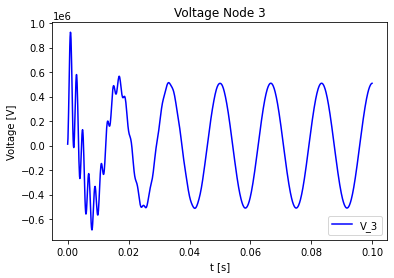

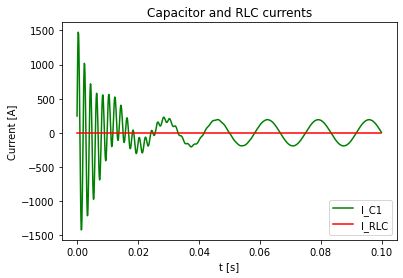

In [69]:
#Read Results

work_dir = 'logs/EMT_Ph1_DufourRLC/'
log_name = 'EMT_Ph1_DufourRLC'
print(work_dir + log_name + '.csv')
ts_emt_ph1_dufour_rlc = rt.read_timeseries_dpsim(work_dir + log_name + '.csv')

#Plot Results

plt.close('all')
fig1 = plt.figure()
plt.plot(ts_emt_ph1_dufour_rlc['v3'].time, ts_emt_ph1_dufour_rlc['v3'].values, "b-", label='V_3')
plt.title('Voltage Node 3')
plt.xlabel('t [s]')
plt.ylabel('Voltage [V]')
plt.legend(loc = 4)
#plt.legend(bbox_to_anchor=(1,1))

fig2 = plt.figure()
plt.plot(ts_emt_ph1_dufour_rlc['i_c1'].time, ts_emt_ph1_dufour_rlc['i_c1'].values, "g-", label='I_C1')
plt.plot(ts_emt_ph1_dufour_rlc['i_rlc'].time, ts_emt_ph1_dufour_rlc['i_rlc'].values, "r-", label='I_RLC')
plt.title('Capacitor and RLC currents')
plt.xlabel('t [s]')
plt.ylabel('Current [A]')
plt.legend(loc = 4)
#plt.legend(bbox_to_anchor=(1,1))



<img src="/EMT_Ph1_SSN_DufourRLC_images/temp.png" width="500" align="left">

In [70]:
import villas.dataprocessing.readtools as rt
import matplotlib.pyplot as plt
import dpsimpy

model_name_SSN = "EMT_Ph1_DufourRLC_SSN";

#Simulation parameters
time_step = 0.0001;
final_time = 0.1;
switch_close_time = 0.05

# Nodes
gnd = dpsimpy.emt.SimNode.gnd
n1 = dpsimpy.emt.SimNode('n1', dpsimpy.PhaseType.Single)
n2 = dpsimpy.emt.SimNode('n2', dpsimpy.PhaseType.Single)
n3 = dpsimpy.emt.SimNode('n3', dpsimpy.PhaseType.Single)
n4 = dpsimpy.emt.SimNode('n4', dpsimpy.PhaseType.Single)

# Components
vs = dpsimpy.emt.ph1.VoltageSource('vs')
vs.set_parameters(V_ref=complex(500000,0), f_src=60)

l1 = dpsimpy.emt.ph1.Inductor('l1')
l1.set_parameters(L = 0.09803)

l2 = dpsimpy.emt.ph1.Inductor('l2')
l2.set_parameters(L = 0.04886)

r1 = dpsimpy.emt.ph1.Resistor('r1')
r1.set_parameters(R = 26.07)

c1 = dpsimpy.emt.ph1.Capacitor('c1')
c1.set_parameters(C=0.000001)

sw = dpsimpy.emt.ph1.Switch('sw')
sw.set_parameters(1e9, 0.001, False)
sw.open()

rlc = dpsimpy.emt.ph1.Full_Serial_RLC('rlc')
rlc.set_parameters(R=50, L=0.01, C=0.000001)

# Assemble circuit
vs.connect([gnd, n1])
l1.connect([n2, n1])
l2.connect([n3, n2])
r1.connect([n3, n2])
c1.connect([gnd, n3])
sw.connect([n4, n3])
rlc.connect([gnd, n4])

system = dpsimpy.SystemTopology(0, [gnd, n1, n2, n3, n4], [vs, l1, l2, r1, c1, sw, rlc])

#Logging
loggerSSN = dpsimpy.Logger(model_name_SSN)
dpsimpy.Logger.set_log_dir('logs/' + model_name_SSN)
loggerSSN.log_attribute('v3', 'v', n3);
loggerSSN.log_attribute('i_rlc', 'i_intf', rlc);
loggerSSN.log_attribute('i_c1', 'i_intf', c1);

#Events
sw_event = dpsimpy.event.SwitchEvent(switch_close_time, sw, True)

#Simulation
sim = dpsimpy.Simulation(model_name_SSN, dpsimpy.LogLevel.debug)
sim.set_system(system)
sim.set_time_step(time_step)
sim.set_final_time(final_time)
sim.set_domain(dpsimpy.Domain.EMT)
sim.do_init_from_nodes_and_terminals(False)
sim.add_logger(loggerSSN)
sim.add_event(sw_event)
sim.run()


5.000000e-02: Handle event time


[22:10:22.335447 EMT_Ph1_DufourRLC_SSN info] Initialize simulation: EMT_Ph1_DufourRLC_SSN
[22:10:22.335643 MnaSolverFactory info] creating EigenDense solver implementation
[22:10:22.336463 EMT_Ph1_DufourRLC_SSN info] Scheduling tasks.
[22:10:22.336868 EMT_Ph1_DufourRLC_SSN info] Scheduling done.
[22:10:22.336872 EMT_Ph1_DufourRLC_SSN info] Opening interfaces.
[22:10:22.336873 EMT_Ph1_DufourRLC_SSN info] Start synchronization with remotes on interfaces
[22:10:22.336875 EMT_Ph1_DufourRLC_SSN info] Synchronized simulation start with remotes
[22:10:22.336878 EMT_Ph1_DufourRLC_SSN info] Start simulation: EMT_Ph1_DufourRLC_SSN
[22:10:22.336882 EMT_Ph1_DufourRLC_SSN info] Time step: 1.000000e-04
[22:10:22.336884 EMT_Ph1_DufourRLC_SSN info] Final time: 1.000000e-01
[22:10:22.393406 EMT_Ph1_DufourRLC_SSN info] Simulation calculation time: 0.056517
[22:10:22.393437 EMT_Ph1_DufourRLC_SSN info] Simulation finished.


In [71]:
#Read Results

work_dir_SSN = 'logs/EMT_Ph1_DufourRLC_SSN/'
log_name_SSN = 'EMT_Ph1_DufourRLC_SSN'
print(work_dir_SSN + log_name_SSN + '.csv')
ts_emt_ph1_dufour_rlc_ssn = rt.read_timeseries_dpsim(work_dir_SSN + log_name_SSN + '.csv')

#Plot Results

fig3 = plt.figure()
plt.plot(ts_emt_ph1_dufour_rlc['v3'].time, ts_emt_ph1_dufour_rlc['v3'].values, "b-", label='V_3')
plt.plot(ts_emt_ph1_dufour_rlc_ssn['v3'].time, ts_emt_ph1_dufour_ssn['v3'].values, "bx", markevery=10, label='V_3_SSN')
plt.title('Voltage Node 3')
plt.xlabel('t [s]')
plt.ylabel('Voltage [V]')
plt.legend(loc = 4)
#plt.legend(bbox_to_anchor=(1,1))

fig4 = plt.figure()
plt.plot(ts_emt_ph1_dufour_rlc['i_c1'].time, ts_emt_ph1_dufour_rlc['i_c1'].values, "g-", label='I_C1')
plt.plot(ts_emt_ph1_dufour_rlc['i_rlc'].time, ts_emt_ph1_dufour_rlc['i_rlc'].values, "r-", label='I_RLC')
plt.plot(ts_emt_ph1_dufour_rlc_ssn['i_c1'].time, ts_emt_ph1_dufour_rlc_ssn['i_c1'].values, "gx", markevery=10, label='I_C1_SSN')
plt.plot(ts_emt_ph1_dufour_rlc_ssn['i_rlc'].time, ts_emt_ph1_dufour_rlc_ssn['i_rlc'].values, "rx", markevery=10, label='I_RLC_SSN')
plt.title('Capacitor and RLC currents')
plt.xlabel('t [s]')
plt.ylabel('Current [A]')
plt.legend(loc = 4)
#plt.legend(bbox_to_anchor=(1,1))



logs/EMT_Ph1_DufourRLC_SSN/EMT_Ph1_DufourRLC_SSN.csv


FileNotFoundError: [Errno 2] No such file or directory: 'logs/EMT_Ph1_DufourRLC_SSN/EMT_Ph1_DufourRLC_SSN.csv'